In [4]:
import os

import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

In [7]:
from dotenv import load_dotenv

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()  # 현재 Jupyter Notebook의 작업 디렉토
env_path = os.path.join(current_dir, '../.env')

# .env 파일 로드
load_dotenv(env_path)

True

In [8]:
db_path=os.getenv("DATA_PATH")
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## 모델 및 하이퍼파라미터 준비
BCResNet의 cnn_first의 stride나 다른 conv의 stride에 따라 입력 또는 출력의 크기가 달라짐.
이는 조절해가면서 실험필요

In [9]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [10]:

from ver4_journal.common.network.BCResNets import BCResNets

tau = 1
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel)

if in_channel == 1:
    sample = torch.randn(1,12,1000)
else:
    sample = torch.randn(1,12,1000)
    #sample = torch.randn(1,12,20,48)

print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 12, 1000])


torch.Size([1, 5])

Class 0 count in ECG_train: 9415
Class 1 count in ECG_train: 7596
Class weights: {0: np.float64(1.8067976633032394), 1: np.float64(2.239468141126909)}
Weight tensor: tensor([1.8068, 2.2395])
Batch shape: torch.Size([32, 12, 1000])
532 67 68
Using mps device


KeyboardInterrupt: 

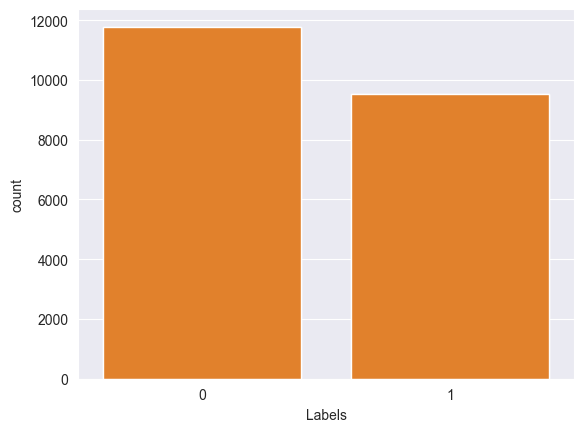

In [11]:
from ver4_journal.common.data.ECG_Data import ECG_Data
from ver4_journal.common.data.create_final_data import create_final_data

# 각각의 BCResNets 학습
for dd in range(5):
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]
    
    final_data=create_final_data(temp, dd)
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)   

    import torch
    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=32, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    print(f"Using {device} device")
    num_epochs = 50
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'../common/best_models/{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

### 테스트 데이터셋 만들기
 - 이전에는 각 분류기를 학습하는 것이기 때문에, 0,1로 레이블을 변경해주었다.
 - 하지만, 직렬로 연결하고 나서는 0,1,2,3,4로 레이블을 변경해야 한다.
  - 훈련하는게 아니므로 train, val은 생략.

In [ ]:
final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)

ECG_test['Labels'].value_counts()

### 현재 모델의 0~4번 순서는 데이터셋의 양에 따라 정해진게 아니다
-  `NORM - STTC - MI - HYP - CD`로 임의로 돼있다.
-  이를 `NORM - MI - STTC - CD - HYP`로 순서를 바꿔야 한다.

In [20]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'./best_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 임계값을 0.05씩 증가시키며 테스트
thresholds = np.arange(0.50, 1.00, 0.05)

for threshold in thresholds:
    print("=====================================================================")
    print(f'\nTesting Serialized Model Pipeline with Threshold: {threshold:.2f}')
    y_true = []
    y_pred = []

    # 테스트 데이터셋을 연결된 모델에 사용
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            # 각 데이터 포인트별로 클래스 레이블을 결정
            for i in range(data.size(0)):  # 배치 내 각 샘플에 대해 반복
                sample = data[i].unsqueeze(0)  # 샘플 하나를 추출
                class_label = None

                # 모든 모델을 순차적으로 거치며, 특정 클래스에 속하는지 확인
                for idx, model in enumerate(best_models):
                    output = model(sample)
                    output = torch.sigmoid(output).item()  # 각 모델의 출력을 sigmoid로 변환하고 스칼라로 변환

                    # 임계값을 넘는 첫 번째 클래스를 찾아 레이블로 지정
                    if output > threshold:
                        class_label = sequence[idx]
                        break

                # 만약 모든 모델의 출력이 임계값 이하라면, OTHER 클래스로 설정
                if class_label is None:
                    class_label = 100  # OTHER 클래스는(100)

                # 최종 클래스 레이블 저장
                y_true.append(label[i].item())  # 샘플의 label 저장
                y_pred.append(class_label)  # 해당 샘플의 예측된 클래스 레이블 저장

    # Confusion Matrix 계산 및 시각화
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 100])
    print(f'임계값: {thresholds}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'], 
                yticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Serialized Model (Threshold: {threshold:.2f})')
    plt.show()
    """
    # Classification Report 추가 (OTHER 클래스 제외)
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['NORM', 'STTC', 'MI', 'HYP', 'CD'], labels=[0, 1, 2, 3, 4], zero_division=0))
    print("=====================================================================")
    


Testing Serialized Model Pipeline with Threshold: 0.50
임계값: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Confusion Matrix:
[[865   0   8   0   2  88]
 [ 40   4  16   7   2 214]
 [ 82   1 309   4   8 140]
 [ 33   2   9  22   4  47]
 [ 48   0  31   1  86  79]
 [  0   0   0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

        NORM       0.81      0.90      0.85       963
        STTC       0.57      0.01      0.03       283
          MI       0.83      0.57      0.67       544
         HYP       0.65      0.19      0.29       117
          CD       0.84      0.35      0.50       245

   micro avg       0.81      0.60      0.69      2152
   macro avg       0.74      0.40      0.47      2152
weighted avg       0.78      0.60      0.63      2152


Testing Serialized Model Pipeline with Threshold: 0.55
임계값: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Confusion Matrix:
[[843   0   4   0   2 114]
 [ 32   0  11   6   1 233]
 [ 64   

In [ ]:
"""
AUC는 직렬화한 multi-stage에는 적합한 지표가 아니다.
왜냐하면, multi-stage는 각 분류기를 학습한 것이지 하나의 모델로 학습한게 아니라
각 stage의 확률의 합이 1이 된다는 보장이 없기 때문이다. (사용시 1이 안된다고 에러 뜸)
따라서 이 코드를 싫행시 에러가 뜨는걸 확인할 수 있다.

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'./best_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 연결된 모델을 사용하여 입력 데이터에 대해 분류를 수행하고 AUC 테스트 수행
print('\nTesting Serialized Model Pipeline')
y_true = []
y_pred_probs = []  # 각 클래스에 대한 확률 저장
y_pred = []  # 예측된 클래스 레이블 저장

# 테스트 데이터셋을 연결된 모델에 사용
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # 각 데이터 포인트별로 클래스 레이블을 결정
        for i in range(data.size(0)):  # 배치 내 각 샘플에 대해 반복
            sample = data[i].unsqueeze(0)  # 샘플 하나를 추출
            class_probs = torch.zeros(len(sequence))  # OTHER 클래스 제외한 각 클래스 확률 저장

            # 모든 모델을 순차적으로 거치며, 특정 클래스에 속하는지 확인
            for idx, model in enumerate(best_models):
                output = model(sample)
                output = torch.sigmoid(output).item()  # 각 모델의 출력을 sigmoid로 변환하고 스칼라로 변환
                class_probs[sequence[idx]] = output

            # 클래스 확률을 레이블 수로 나누어 정규화하여 AUC 계산에 사용
            normalized_probs = class_probs / len(sequence)  # 클래스 수로 나누어 정규화

            # 임계값(0.5)을 넘는 첫 번째 클래스를 찾아 레이블로 지정
            class_label = 100  # 기본적으로 OTHER 클래스로 설정
            for idx, prob in enumerate(class_probs):
                if prob > 0.5:
                    class_label = sequence[idx]
                    break

            # 최종 클래스 확률 저장 및 예측 레이블 저장
            y_true.append(label[i].item())  # 샘플의 label 저장
            y_pred_probs.append(normalized_probs.cpu().numpy())  # 해당 샘플의 예측된 클래스 확률 저장
            y_pred.append(class_label)  # 해당 샘플의 예측된 클래스 레이블 저장

# AUC 및 Confusion Matrix 계산
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.array(y_pred)

# 다중 클래스 AUC 계산 (OTHER 클래스는 AUC 계산에 사용하지 않음)
try:
    auc_ovo = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovo', labels=[0, 1, 2, 3, 4])
    auc_ovr = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovr', labels=[0, 1, 2, 3, 4])
    print(f'Macro AUC OVO for Serialized Model: {auc_ovo:.4f}')
    print(f'Macro AUC OVR for Serialized Model: {auc_ovr:.4f}')
    print(f'Overall Performance Metrics: OVO AUC = {auc_ovo:.4f}, OVR AUC = {auc_ovr:.4f}')
except ValueError as e:
    print(f"AUC calculation error: {e}")

# Confusion Matrix 계산 및 시각화
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 100])
print(f'Confusion Matrix:\n{conf_matrix}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'], 
            yticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Serialized Model')
plt.show()

# Classification Report 추가 (OTHER 클래스 제외)
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['NORM', 'STTC', 'MI', 'HYP', 'CD'], labels=[0, 1, 2, 3, 4]))
"""